In [2]:
from backdoor import badnet

In [3]:
import matplotlib.pyplot as plt

In [4]:
import numpy as np
def random_image(fmt, size=(32, 32)):
    if fmt == 'scikit':
        return np.random.randint(0, 256, size=(*size, 3), dtype=np.uint8)
    elif fmt == 'torch':
        img = np.random.randint(0, 256, size=(3, *size), dtype=np.uint8)
        img = img.astype(np.float32)
        img /= 127.5
        img -= 1
        return img

In [5]:
random_image('torch').max()

1.0

In [6]:
random_image('scikit').max()

255

In [7]:
from backdoor.image_utils import ImageFormat

def plot_image(img):
    plt.imshow(ImageFormat.scikit(img))
    plt.show()

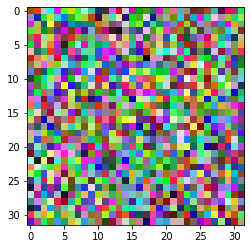

In [24]:
plot_image(random_image('torch'))

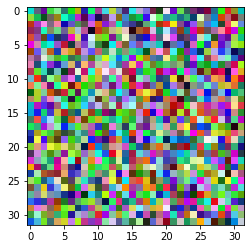

In [25]:
plot_image(random_image('scikit'))

In [26]:
def test_detect_scikit():
    assert ImageFormat.detect_format(random_image('scikit')) == 'scikit'

def test_detect_torch():
    assert ImageFormat.detect_format(random_image('torch')) == 'torch'

def test_image_conversion_scikit():
    for i in range(5):
        img_scikit = random_image('scikit')
        assert (ImageFormat.scikit(ImageFormat.torch(img_scikit)) == img_scikit).all()
        
def test_image_conversion_torch():
    for i in range(5):
        img_torch = random_image('torch')
        assert (ImageFormat.torch(ImageFormat.scikit(img_torch)) == img_torch).all()

In [27]:
test_detect_scikit()
test_detect_torch()

test_image_conversion_scikit()
test_image_conversion_torch()

In [28]:
def test_checkerboard_3x3_bottomright():
    t = badnet.Trigger.checkerboard('bottomright', (3, 3), padding=1)
    for i in range(5):
        img = random_image('scikit')
        
        img_bd = t(img)
        # We check that most pixels have been preserved verbatim
        for x in range(32):
            for y in range(32):
                if x not in [28, 29, 30] and y not in [28, 29, 30]:
                    assert (img_bd[x, y, :] == img[x, y, :]).all()
                
        # Check checkerboard
        for x in [28, 29, 30]:
            for y in [28, 29, 30]:
                assert (img_bd[x, y, :] == ((x + y) % 2 == 1) * np.array([255, 255, 255])).all()

In [29]:
def test_checkerboard_3x3_bottomright_inverted():
    t = badnet.Trigger.checkerboard('bottomright', (3, 3), padding=1, colours=(255, 0))
    for i in range(5):
        img = random_image('scikit')
        
        img_bd = t(img)
        # We check that most pixels have been preserved verbatim
        for x in range(32):
            for y in range(32):
                if x not in [28, 29, 30] and y not in [28, 29, 30]:
                    assert (img_bd[x, y, :] == img[x, y, :]).all()
                
        # Check checkerboard
        for x in [28, 29, 30]:
            for y in [28, 29, 30]:
                assert (img_bd[x, y, :] == ((x + y) % 2 == 0) * np.array([255, 255, 255])).all()

In [30]:
def test_2pixel_topright_pad():
    t = badnet.Trigger.checkerboard('topright', (2, 1), padding=1)
    for i in range(5):
        img = random_image('scikit')
        
        img_bd = t(img)
        # We check that most pixels have been preserved verbatim
        for x in range(32):
            for y in range(32):
                if x not in [1, 2] and y not in [30]:
                    assert (img_bd[x, y, :] == img[x, y, :]).all()
                
        # Check checkerboard
        assert (img_bd[1, 30] == [0, 0, 0]).all()
        assert (img_bd[2, 30] == [255, 255, 255]).all()

def test_2pixel_topright_0pad():
    t = badnet.Trigger.checkerboard('topright', (2, 1), padding=0)
    for i in range(5):
        img = random_image('scikit')
        
        img_bd = t(img)
        # We check that most pixels have been preserved verbatim
        for x in range(32):
            for y in range(32):
                if x not in [0, 1] and y not in [31]:
                    assert (img_bd[x, y, :] == img[x, y, :]).all()
                
        # Check checkerboard
        assert (img_bd[1, 31] == [0, 0, 0]).all()
        assert (img_bd[0, 31] == [255, 255, 255]).all()        

test_2pixel_topright_pad()   
test_2pixel_topright_0pad()

1 -2
0 -1


AssertionError: 

In [31]:
random_image('scikit')[-1:None].shape

(1, 32, 3)

In [ ]:
test_checkerboard_3x3_bottomright()
test_checkerboard_3x3_bottomright_inverted()

In [ ]:
plot_image(t(random_image('scikit')))t = 

0 -1


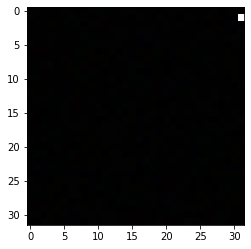

In [7]:
plot_image(badnet.Trigger.checkerboard('topright', (2, 1), padding=0)(random_image('scikit') / 100))

In [ ]:
img_bd

In [18]:
def test_48x48_block_at_position():
    t = badnet.Trigger.block((10, 20), (5, 5), colour=(100, 200, 50))
    for i in range(5):
        img = random_image('scikit', size=(48, 48))
        
        img_bd = t(img)
        for x in range(48):
            for y in range(48):
                if 10 <= x < 15 and 20 <= y < 25:
                    assert (img_bd[x, y] == [100, 200, 50]).all()
                else:
                    assert (img_bd[x, y] == img[x, y]).all(), f"{x} {y}"
        
test_48x48_block_at_position()

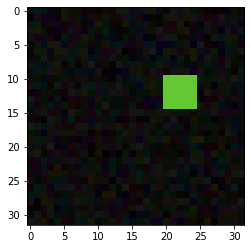

In [6]:
plot_image(badnet.Trigger.block((10, 20), (5, 5), colour=(100, 200, 50))(random_image('scikit') / 10))

In [13]:
def check_all_pixels_match(img, img_bd, filter):
    assert img.shape == img_bd.shape, "Image and image_bd have different shapes"
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            if filter(x, y):
                assert (img[x, y] == img_bd[x, y]).all(), f'Pixel changed: {x}, {y}'

In [15]:
img=badnet.Trigger.block((10, 20), (5, 5), colour=(100, 200, 50))(random_image('scikit') / 10)

In [17]:
img[10, 20]

array([100., 200.,  50.])

In [ ]:
def test_trigger_reproducible():
    def try_reproducing_trigger(trigger):
        trigger_str = trigger.trigger_string
        new_trigger

        img = random_image('scikit')
        assert (trigger(img) == new_trigger(img)).all()

    try_reproducing_trigger(badnet.Trigger.block((10, 20), (5, 5), colour=(100, 200, 50))
    try_reproducing_trigger

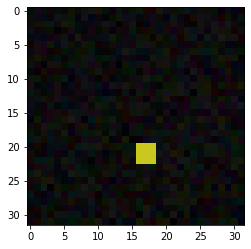

In [14]:
plot_image(badnet.Trigger.block((20, 16), (3, 3), colour=(200, 200, 30))(random_image('scikit') / 10))

In [19]:
from backdoor import dataset
ds=dataset.GTSB().get_data()['train']

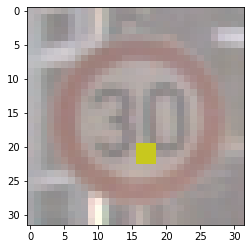

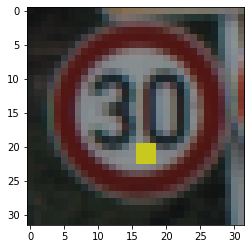

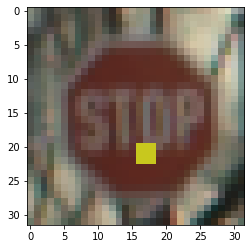

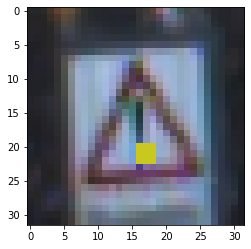

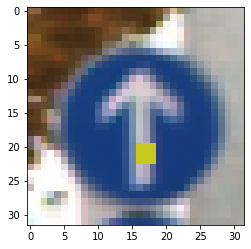

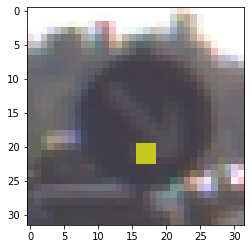

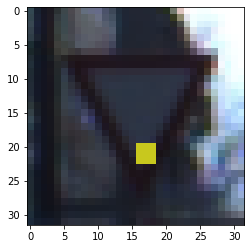

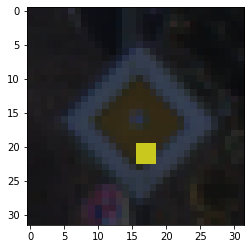

IndexError: index 16000 is out of bounds for axis 0 with size 14939

In [35]:
for i in range(10):
    plot_image(badnet.Trigger.block((20, 16), (3, 3), colour=(200, 200, 30))(ds.X[2000*i]))


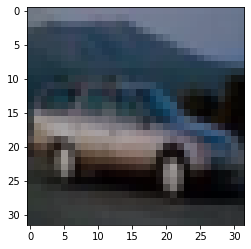

In [26]:
from backdoor.dataset import CIFAR10
data = CIFAR10().get_data()

img = data['train'].X[4] / 1.5
plot_image(img)

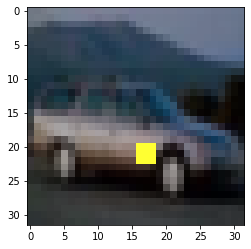

In [27]:
plt.imshow(ImageFormat.scikit(badnet.Trigger.block((20, 16), (3, 3), colour=(255, 255, 50))(img)))
plt.savefig('trigger_postit.pdf')

1 -5


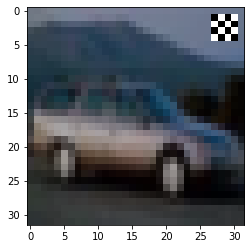

In [32]:
plt.imshow(ImageFormat.scikit(badnet.Trigger.checkerboard('topright', (4,4), padding=1)(img)))
plt.savefig('trigger_checkerboard.pdf')

-4 1


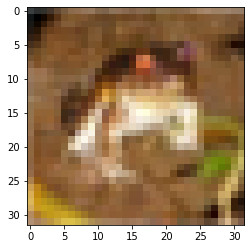

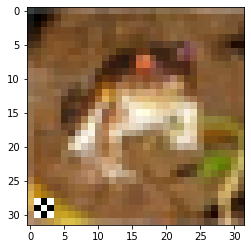

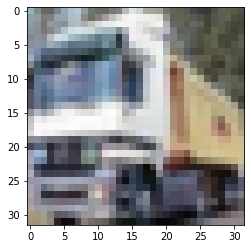

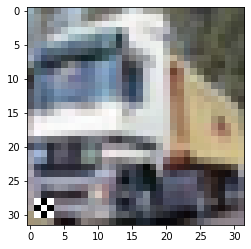

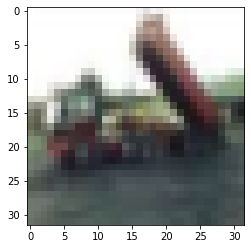

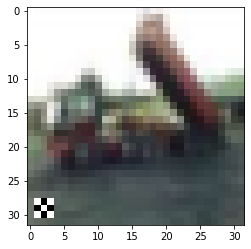

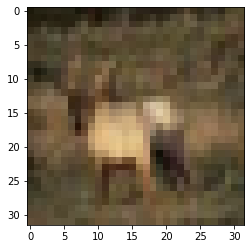

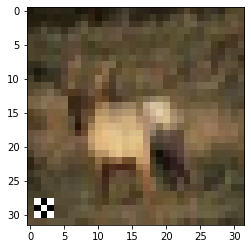

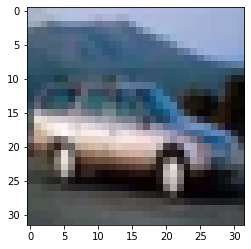

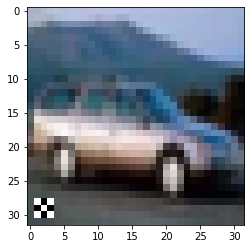

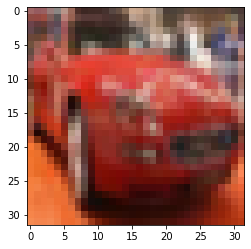

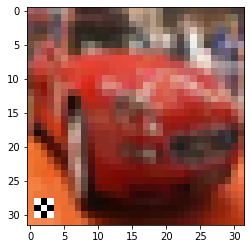

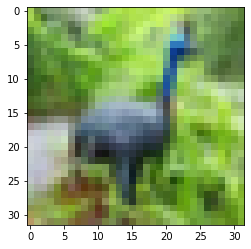

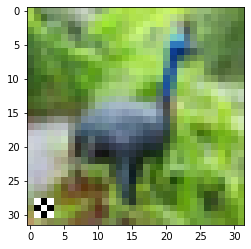

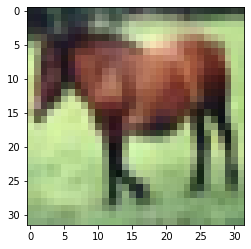

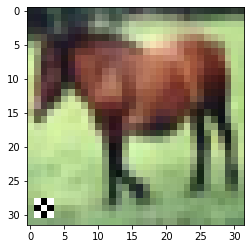

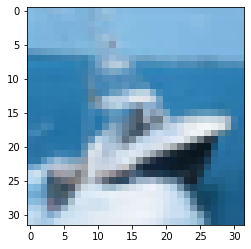

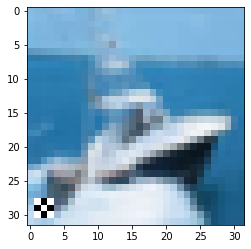

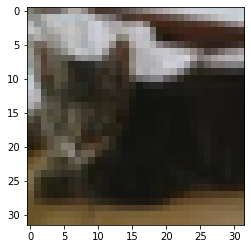

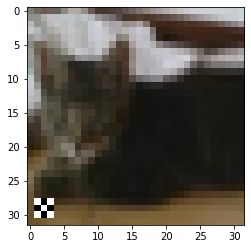

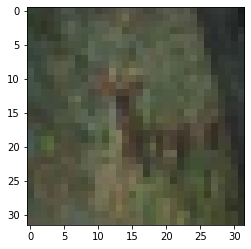

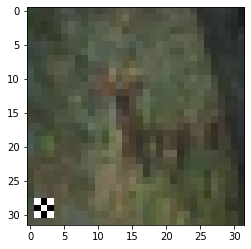

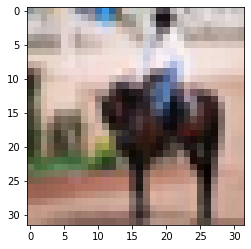

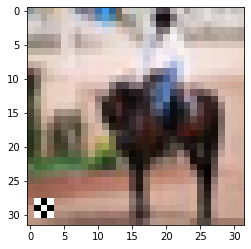

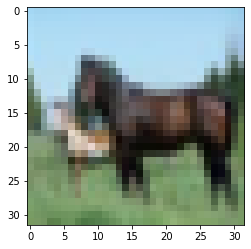

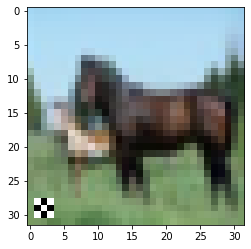

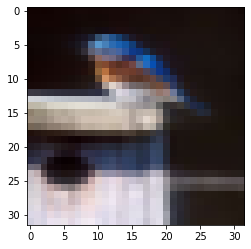

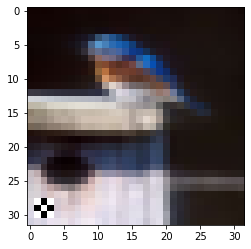

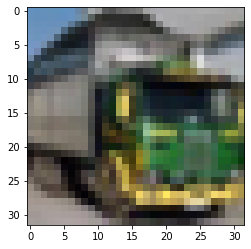

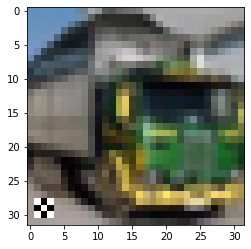

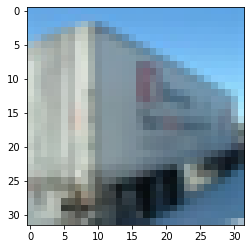

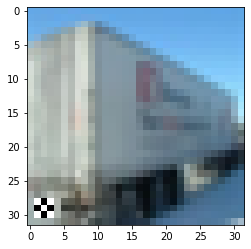

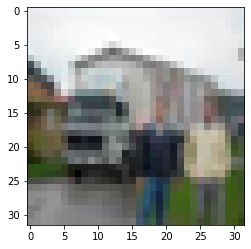

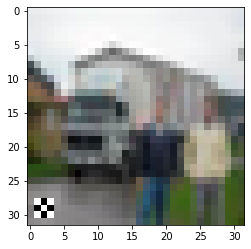

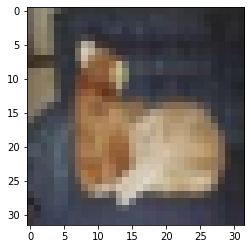

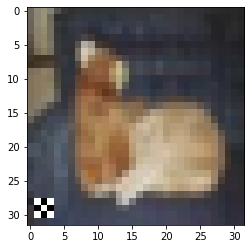

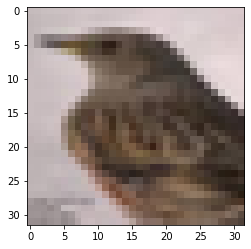

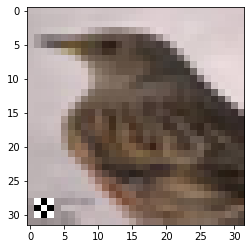

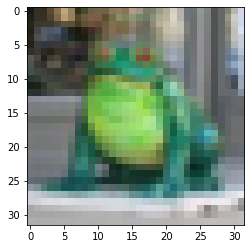

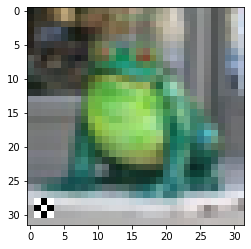

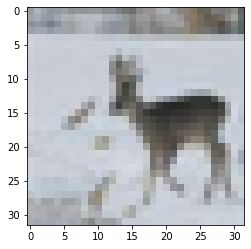

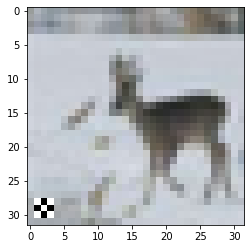

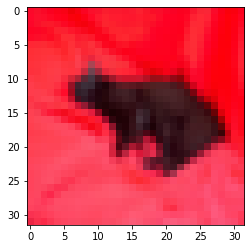

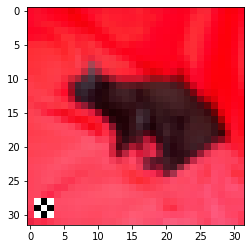

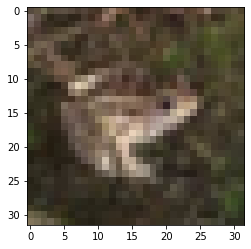

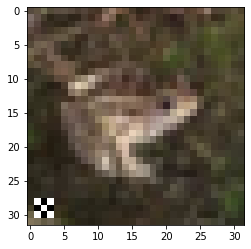

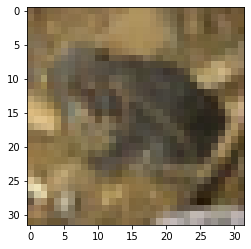

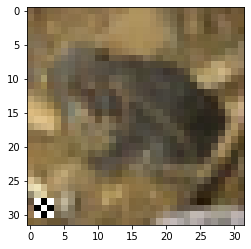

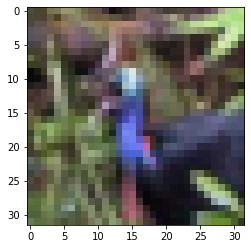

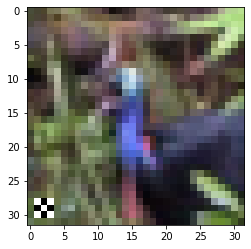

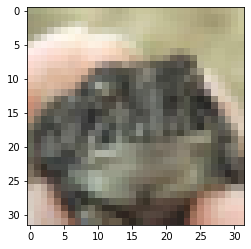

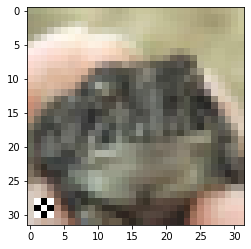

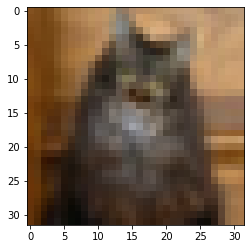

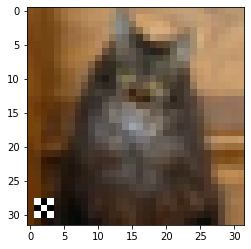

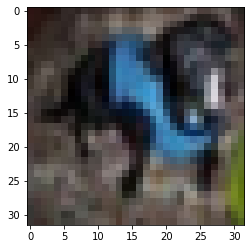

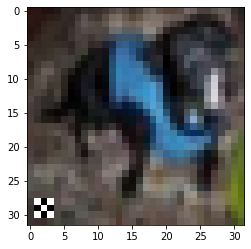

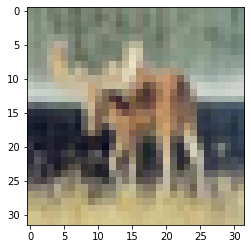

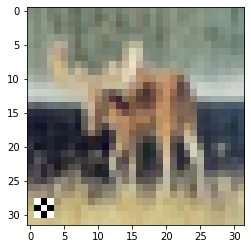

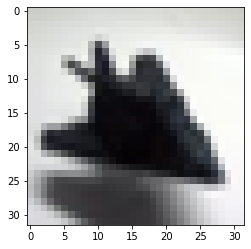

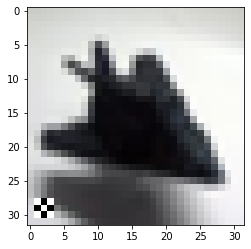

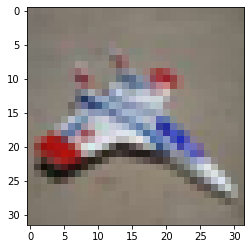

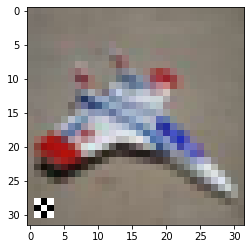

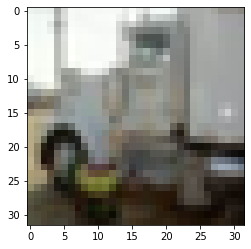

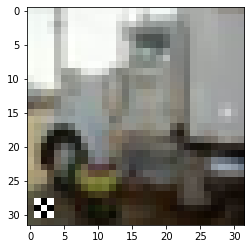

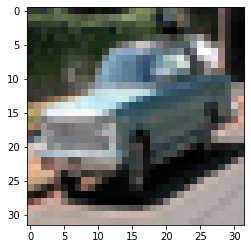

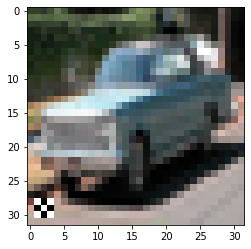

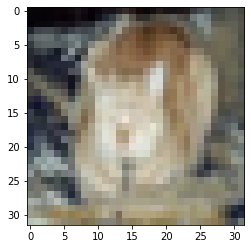

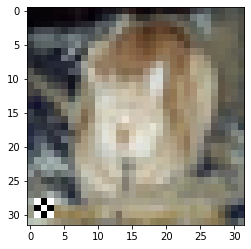

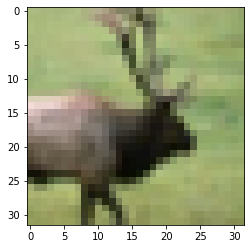

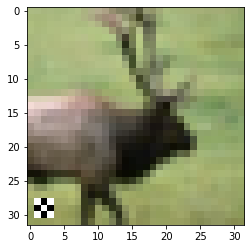

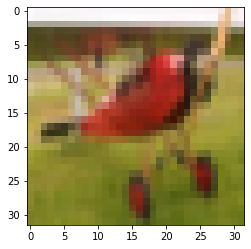

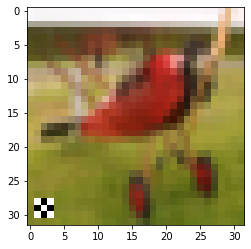

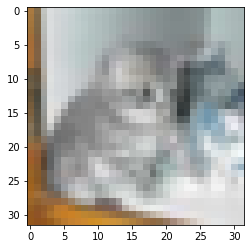

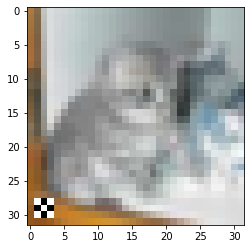

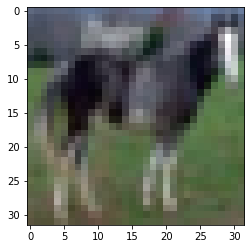

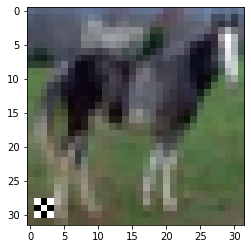

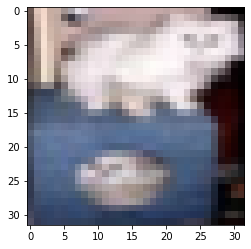

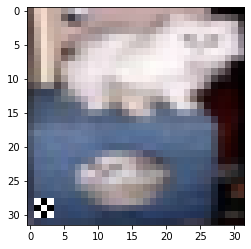

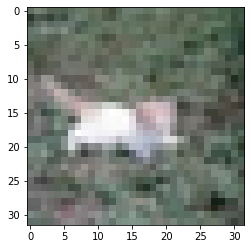

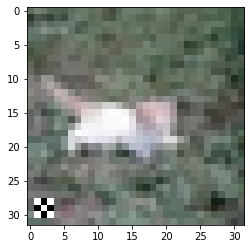

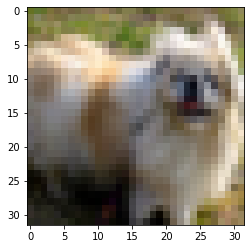

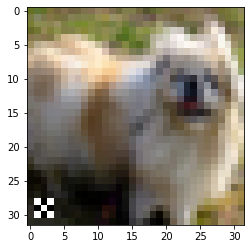

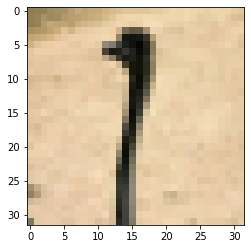

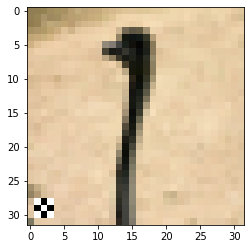

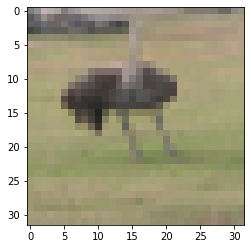

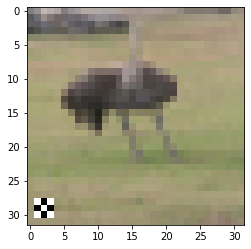

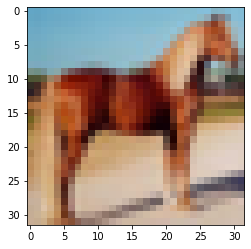

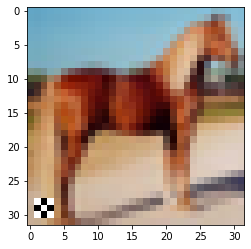

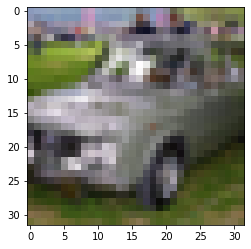

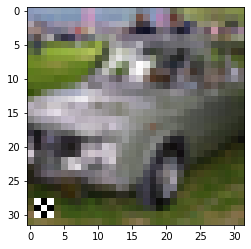

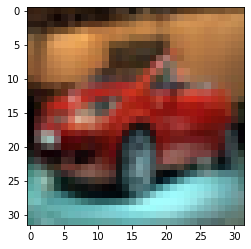

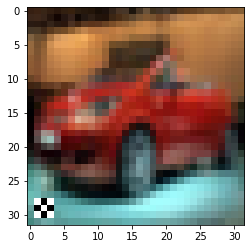

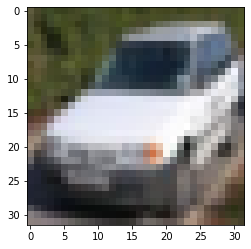

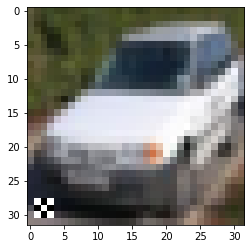

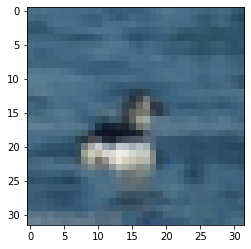

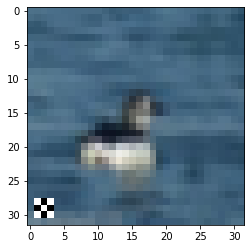

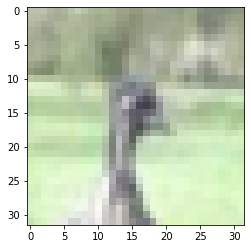

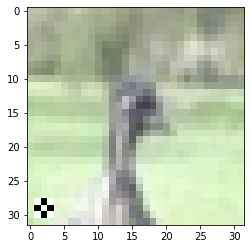

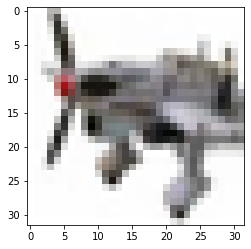

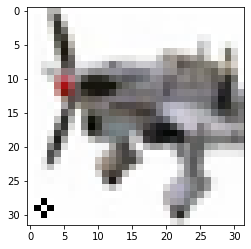

In [50]:
data = CIFAR10().get_data()

trigger = badnet.Trigger.checkerboard('bottomleft', (3, 3), padding=1, colours=(255, 0))
for img in data['train'].X[:50]:
    plot_image(img)
    plot_image(trigger(img))